In [ ]:
!pip install tqdm
!pip install efficientnet_pytorch
!pip install torch torchvision
!pip install efficientnet_pytorch


In [45]:
import pandas as pd 
df=pd.read_csv("/kaggle/input/car-crash-dataset-ccd/Crash_Table.csv")

In [48]:
df

,vidname,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,...,frame_46,frame_47,frame_48,frame_49,frame_50,startframe,youtubeID,timing,weather,egoinvolve
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,285,0,Day,Normal,Yes
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,646,0,Day,Normal,Yes
2,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,972,0,Day,Normal,Yes
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1257,0,Day,Normal,Yes
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,462,10,Day,Snowy,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1496,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2116,169,Day,Snowy,Yes
1496,1497,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,2591,169,Day,Normal,Yes
1497,1498,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,4798,169,Day,Snowy,Yes
1498,1499,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,548,170,Day,Snowy,No


In [49]:
result = []

for index, row in df.iterrows():
    vid_number = row['vidname']
    for frame_num in range(1, 51):  # Adjust the range based on the number of frames
        if row[f'frame_{frame_num}'] == 1:
            result.append((vid_number, frame_num))

# Convert result to DataFrame for better readability
result_df = pd.DataFrame(result, columns=['vidname', 'frame_number'])

print(result_df)

       vidname  frame_number
0            1            33
1            1            34
2            1            35
3            1            36
4            1            37
...        ...           ...
19211     1500            46
19212     1500            47
19213     1500            48
19214     1500            49
19215     1500            50

[19216 rows x 2 columns]


In [67]:
result_df

,vidname,frame_number
0,1,33
1,1,34
2,1,35
3,1,36
4,1,37
...,...,...
19211,1500,46
19212,1500,47
19213,1500,48
19214,1500,49


In [66]:
import os
import shutil
import pandas as pd

# Sample result DataFrame (you would use your actual DataFrame)
# result_data = {
#     'vidname': [1, 5, 1497],  # Example video IDs with frames containing 1
#     'frame_number': [4, 5, 3]  # Example frame numbers
# }

# result_df = pd.DataFrame(result_data)

# Define paths
source_folder = '/kaggle/input/car-crash-dataset-ccd'  # Folder containing the original images
output_included_folder = '/kaggle/working/data/included'  # Folder for images included in result_df
output_excluded_folder = '/kaggle/working/data/excluded'  # Folder for images not included in result_df

# Create output directories if they do not exist
os.makedirs(output_included_folder, exist_ok=True)
os.makedirs(output_excluded_folder, exist_ok=True)

# Set to hold filenames to include
included_files = set()

# Generate the filenames for the images that should be included
for _, row in result_df.iterrows():
    vid_id = f"{row['vidname']:06d}"  # Zero-padded video ID (6 digits)
    frame_number = f"{row['frame_number']:02d}"  # Zero-padded frame number (2 digits)
    
    # Construct the filename
    filename = f"C_{vid_id}_{frame_number}.jpg"
    included_files.add(filename)

# Copy included images
for filename in included_files:
    src_file = os.path.join(source_folder, filename)
    if os.path.exists(src_file):
        shutil.copy(src_file, output_included_folder)

# Copy excluded images
for filename in os.listdir(source_folder):
    if filename.endswith('.jpg') and filename not in included_files:
        src_file = os.path.join(source_folder, filename)
        shutil.copy(src_file, output_excluded_folder)

print("Image extraction completed.")


Image extraction completed.


In [5]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [75]:
from torchvision import transforms

# Define augmentations for training data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to the input size required by EfficientNet
    transforms.RandomHorizontalFlip(),       # Randomly flip the images horizontally
    transforms.RandomRotation(10),           # Rotate images by up to 10 degrees
     transforms.ToTensor(),                   # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])

# Define simple transforms for validation data
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [76]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from PIL import UnidentifiedImageError, Image
from tqdm import tqdm

# Define a custom dataset class to handle corrupted images
class CleanImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super(CleanImageFolder, self).__getitem__(index)
        except (UnidentifiedImageError, OSError):
            # If there's an error, skip this image
            return None, None

# Example dataset path
train_dir = '/kaggle/working/data'

# Load the dataset with the augmentations applied to the training data
full_dataset = CleanImageFolder(root=train_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply val_transform to validation dataset
val_dataset.dataset.transform = val_transform

# Define batch size
batch_size = 64

# Filter out None samples when loading
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

# Create data loaders with a custom collate_fn to skip corrupted images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [77]:
model = EfficientNet.from_pretrained('efficientnet-b0')
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, 2)
model = model.to(device)


Loaded pretrained weights for efficientnet-b0


In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [87]:
import pickle
from tqdm import tqdm

# Initialize variables to save training history
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Training Phase
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_loader_tqdm.set_postfix({"Loss": loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Training Loss: {epoch_loss:.7f}")
    history["train_loss"].append(epoch_loss)  # Save training loss for this epoch

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            val_loader_tqdm.set_postfix({"Loss": loss.item()})

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.7f}, Validation Accuracy: {val_accuracy:.7f}%\n")

    # Save validation loss and accuracy for this epoch
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_accuracy)

# Save the history to a file after training
with open("training_history.pkl", "wb") as f:
    pickle.dump(history, f)

print("Training history saved to 'training_history.pkl'")


Epoch 1/10:


Training Loss: 0.1712324


Validation Loss: 0.2435947, Validation Accuracy: 90.9825689%

Epoch 2/10:


Training Loss: 0.1275822


Validation Loss: 0.2576619, Validation Accuracy: 91.8784692%

Epoch 3/10:


Training Loss: 0.0991206


Validation Loss: 0.2153218, Validation Accuracy: 93.4560327%

Epoch 4/10:


Training Loss: 0.0828157


Validation Loss: 0.2144520, Validation Accuracy: 92.0342779%

Epoch 5/10:


Training Loss: 0.0721151


Validation Loss: 0.2167453, Validation Accuracy: 93.6118415%

Epoch 6/10:


Training Loss: 0.0671500


Validation Loss: 0.3576623, Validation Accuracy: 88.3338202%

Epoch 7/10:


Training Loss: 0.0569159


Validation Loss: 0.2114838, Validation Accuracy: 93.3197001%

Epoch 8/10:


Training Loss: 0.0557097


Validation Loss: 0.3399365, Validation Accuracy: 90.9825689%

Epoch 9/10:


Training Loss: 0.0529155


Validation Loss: 0.2551694, Validation Accuracy: 93.2028435%

Epoch 10/10:


Training Loss: 0.0484786


Validation Loss: 0.2311939, Validation Accuracy: 93.9039829%

Training history saved to 'training_history.pkl'


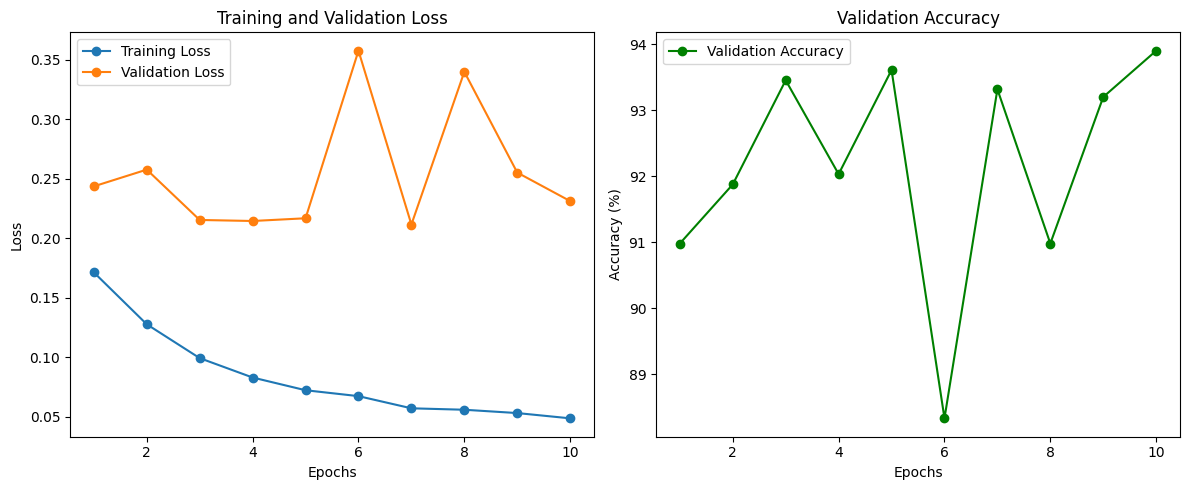

In [88]:
import matplotlib.pyplot as plt
import pickle

# Load the history from the saved file
with open("training_history.pkl", "rb") as f:
    history = pickle.load(f)

# Extract data from the history
train_loss = history["train_loss"]
val_loss = history["val_loss"]
val_accuracy = history["val_accuracy"]
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Validation Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker='o', color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [89]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    # Wrap the validation loader with tqdm
    for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc="Validation", leave=False)):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nValidation Accuracy: {100 * correct / total:.2f}%")



Validation Accuracy: 93.90%


In [41]:
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10042.jpg'  # Replace with your image path
image = Image.open(image_path)

# Define the transformations (make sure they match the train/val transforms)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to the input size expected by EfficientNet
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
# ])

# Apply transformations

image = val_transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(device)  # Move to the appropriate device


In [42]:
# Put the model in evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    outputs = model(image)  # Forward pass
    _, predicted = torch.max(outputs, 1)  # Get the predicted class

# Print the predicted class
print(f'Predicted class: {predicted.item()}')  # Use .item() to get the integer class label


Predicted class: 1


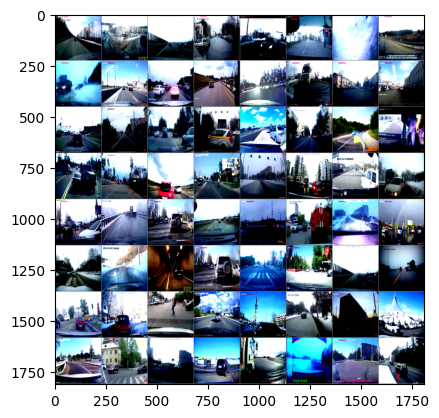

Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0])


In [90]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print('Labels:', labels)


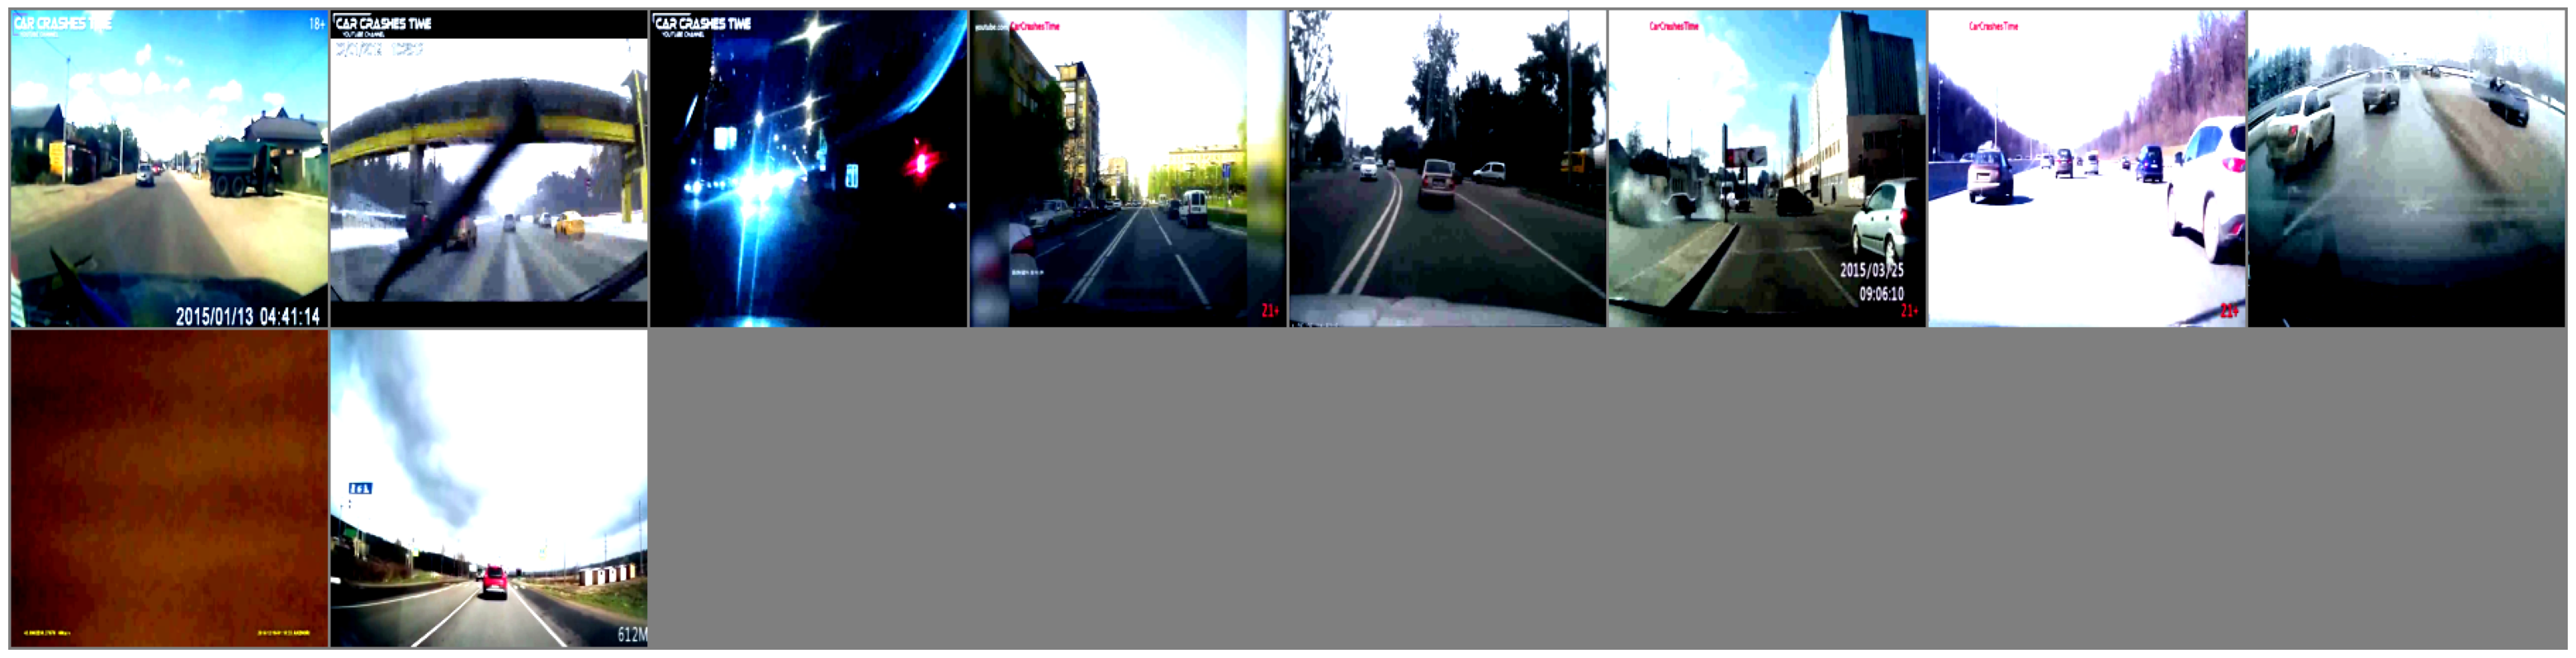

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0])


In [93]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and display images with specified figure size and fewer images
def imshow(img, num_images=4, figsize=(8, 8)):
    img = img[:num_images]  # Select a subset of images
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a subset of images with a larger plot size
imshow(torchvision.utils.make_grid(images[:10]), num_images=10, figsize=(40, 40))  # Adjust num_images and figsize as desired
print('Labels:', labels[:10])  # Display labels for the subset of images
